### wavオーディオをクリップに分割
ジャンル名を適宜変える

In [215]:
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
import os
import glob

# パラメータ設定
clip_length_ms = 10 * 1000  
overlap_ms = 0 * 1000     
hop_ms = clip_length_ms - overlap_ms  # 10秒ごとにスライド
silence_thresh_db = -55     # 無音とみなす音量（dB）
min_silence_len_ms = 3000    # 無音とみなす最小継続時間（ミリ秒）

# 入出力ディレクトリ
input_pattern = os.path.join("ballad", "**", "vocal_percussion.wav")
input_files = glob.glob(input_pattern, recursive=True)
output_dir = "output_clips_30/ballad"
os.makedirs(output_dir, exist_ok=True)

# フルパスに変換して処理
for file_path in input_files:
    audio = AudioSegment.from_wav(file_path)
    filename = os.path.splitext(os.path.basename(os.path.dirname(file_path)))[0]  # フォルダ名をベースに使う
    # 無音でない区間を検出して抽出
    nonsilent_ranges = detect_nonsilent(audio, min_silence_len=min_silence_len_ms, silence_thresh=silence_thresh_db)
    
    if not nonsilent_ranges:
        print(f"No nonsilent audio detected in {file_path}")
        continue

    # 無音を取り除いた新しい音声
    non_silent_audio = AudioSegment.empty()
    for start_i, end_i in nonsilent_ranges:
        non_silent_audio += audio[start_i:end_i]

    # 分割処理
    start = 0
    clip_index = 0
    duration_ms = len(non_silent_audio)
    while start < duration_ms:
        end = min(start + clip_length_ms, duration_ms)
        clip = non_silent_audio[start:end]
        # 30秒未満のクリップはスキップ
        if len(clip) < clip_length_ms:
            break  # 以降すべて30秒未満になるので終了
        output_path = os.path.join(output_dir, f"{filename}/clip{clip_index:03d}.wav")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        clip.export(output_path, format="wav")
        print(f"Saved: {output_path}")
        clip_index += 1
        start += hop_ms


Saved: output_clips_30/ballad/kakashi/clip000.wav
Saved: output_clips_30/ballad/kakashi/clip001.wav
Saved: output_clips_30/ballad/kakashi/clip002.wav
Saved: output_clips_30/ballad/kakashi/clip003.wav
Saved: output_clips_30/ballad/kakashi/clip004.wav
Saved: output_clips_30/ballad/kakashi/clip005.wav
Saved: output_clips_30/ballad/kakashi/clip006.wav
Saved: output_clips_30/ballad/kakashi/clip007.wav
Saved: output_clips_30/ballad/nakayoshikomichi/clip000.wav
Saved: output_clips_30/ballad/nakayoshikomichi/clip001.wav
Saved: output_clips_30/ballad/nakayoshikomichi/clip002.wav
Saved: output_clips_30/ballad/nakayoshikomichi/clip003.wav
Saved: output_clips_30/ballad/shikararete/clip000.wav
Saved: output_clips_30/ballad/shikararete/clip001.wav
Saved: output_clips_30/ballad/shikararete/clip002.wav
Saved: output_clips_30/ballad/shikararete/clip003.wav
Saved: output_clips_30/ballad/shikararete/clip004.wav
Saved: output_clips_30/ballad/doubutsuen/clip000.wav
Saved: output_clips_30/ballad/doubutsuen/

### 特定のジャンルの全てのクリップを読み込む

In [246]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# すべての .wav ファイルを ballad 以下から再帰的に取得
files = glob.glob("output_clips_30/soulfunk/**/*.wav", recursive=True)

# ③ ラベル（ファイル名）を生成
labels = [os.path.splitext(os.path.basename(f))[0] for f in files]

# ④ 確認
print("読み込むファイル数:", len(files))
for f in files:
    print(f)


読み込むファイル数: 27
output_clips_30/soulfunk/dokokadeharuga/clip004.wav
output_clips_30/soulfunk/dokokadeharuga/clip002.wav
output_clips_30/soulfunk/dokokadeharuga/clip003.wav
output_clips_30/soulfunk/dokokadeharuga/clip001.wav
output_clips_30/soulfunk/dokokadeharuga/clip000.wav
output_clips_30/soulfunk/makibanoasa/clip004.wav
output_clips_30/soulfunk/makibanoasa/clip002.wav
output_clips_30/soulfunk/makibanoasa/clip003.wav
output_clips_30/soulfunk/makibanoasa/clip001.wav
output_clips_30/soulfunk/makibanoasa/clip000.wav
output_clips_30/soulfunk/inu/clip004.wav
output_clips_30/soulfunk/inu/clip005.wav
output_clips_30/soulfunk/inu/clip002.wav
output_clips_30/soulfunk/inu/clip003.wav
output_clips_30/soulfunk/inu/clip001.wav
output_clips_30/soulfunk/inu/clip000.wav
output_clips_30/soulfunk/akaiboushishiroiboushi/clip004.wav
output_clips_30/soulfunk/akaiboushishiroiboushi/clip002.wav
output_clips_30/soulfunk/akaiboushishiroiboushi/clip003.wav
output_clips_30/soulfunk/akaiboushishiroiboushi/clip001

## SFM
#### 計算して'sfm_features.csv'に追加

In [6]:
import pandas as pd
import numpy as np
import librosa
import os

# パラメータ
n_bands = 24  # サブバンド数
output_csv = 'sfm_features_30.csv'  # 結果保存先

# 既にファイルがあるかどうかでヘッダーの有無を決める
file_exists = os.path.isfile(output_csv)

for filename in files:
    # 音声読み込み
    y, sr = librosa.load(filename, sr=None)

    # メルスペクトログラム計算
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_bands, fmax=sr//2)

    # 各バンドごとのSFMを計算（平均）
    geo_mean = np.exp(np.mean(np.log(np.maximum(S, 1e-10)), axis=1))  # ジオ平均
    arith_mean = np.mean(S, axis=1)  # 算術平均
    sfm_bands = geo_mean / arith_mean  # 各バンドのSFM

    # 特徴ベクトルを保存
    feature = {'filename': filename}
    for i in range(n_bands):
        feature[f'sfm_band_{i+1}'] = sfm_bands[i]

    # DataFrameにしてCSVに追記
    df = pd.DataFrame([feature])
    df.to_csv(output_csv, mode='a', header=not file_exists, index=False)
    file_exists = True  # 2回目以降はヘッダーなしで追記


NameError: name 'files' is not defined

## ここまでを全てのジャンルで行ってから次へ

#### AdaBoost

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

# 新しくアップロードされたファイルを読み込み、同様の前処理を実行する
file_path = 'data/sfm_features.csv'
df = pd.read_csv(file_path)

# ジャンルラベルをファイル名から抽出
df['label'] = df['filename'].apply(lambda x: x.split('/')[1])

# ジャンルごとのサンプル数を確認（エラーの原因確認）
label_counts = df['label'].value_counts()
label_counts


# 特徴量とラベルの準備
X = df[[col for col in df.columns if col.startswith('sfm_band_')]]
y = df['label']

# 層化抽出で分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# モデル学習
clf = AdaBoostClassifier(random_state=42)
clf.fit(X_train, y_train)

# 評価
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      ballad       0.13      1.00      0.23         3
  bossa_nova       0.00      0.00      0.00         4
         edm       0.00      0.00      0.00         5
        enka       0.00      0.00      0.00         3
        jazz       0.00      0.00      0.00         1
     neutral       0.00      0.00      0.00         3
     popular       0.75      1.00      0.86         3
   punk_rock       0.00      0.00      0.00         3
      reggae       0.00      0.00      0.00         2
    soulfunk       1.00      1.00      1.00         3

    accuracy                           0.30        30
   macro avg       0.19      0.30      0.21        30
weighted avg       0.19      0.30      0.21        30



/Users/rinkanobukawa/Downloads/VP/jaCappella/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rinkanobukawa/Downloads/VP/jaCappella/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rinkanobukawa/Downloads/VP/jaCappella/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

#### SVM

In [185]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# 新しくアップロードされたファイルを読み込み、同様の前処理を実行する
file_path = 'sfm_features.csv'
df = pd.read_csv(file_path)

# ジャンルラベルをファイル名から抽出
df['label'] = df['filename'].apply(lambda x: x.split('/')[1])
# 特徴量とラベルの準備
X = df[[col for col in df.columns if col.startswith('sfm_band_')]]
y = df['label']

# 特徴量のスケーリング（SVMでは重要）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 層化抽出で訓練・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# SVMモデルの訓練（RBFカーネル）
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
clf.fit(X_train, y_train)

# テストデータで予測し、評価レポートを出力
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      ballad       0.00      0.00      0.00         3
  bossa_nova       0.75      0.50      0.60         6
         edm       0.67      0.86      0.75         7
        enka       0.20      0.60      0.30         5
        jazz       1.00      0.67      0.80         3
     neutral       0.50      0.60      0.55         5
     popular       1.00      0.60      0.75         5
   punk_rock       1.00      0.60      0.75         5
      reggae       1.00      0.50      0.67         4
    soulfunk       1.00      0.80      0.89         5

    accuracy                           0.60        48
   macro avg       0.71      0.57      0.61        48
weighted avg       0.72      0.60      0.63        48



/Users/rinkanobukawa/Downloads/VP/jaCappella/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rinkanobukawa/Downloads/VP/jaCappella/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rinkanobukawa/Downloads/VP/jaCappella/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

## ASE
#### 計算して'ase_features.csv'に追加

In [4]:
import librosa
import numpy as np
import pandas as pd

# 帯域定義
band_edges = np.array([
    0, 50, 150, 250, 500, 1000, 3000, 5000, 8000, 12000, 16000, 22050
])

# SFMファイルからファイル名を取得
df_sfm = pd.read_csv("sfm_features_30.csv")  # 自分のパスに変更
files = df_sfm['filename'].tolist()

# 特徴量計算
ase_band_features = []

for filename in files:
    try:
        y, sr = librosa.load(filename, sr=None)
        S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))**2
        freqs = np.linspace(0, sr/2, S.shape[0])

        ase_bands = []
        for i in range(len(band_edges) - 1):
            fmin, fmax = band_edges[i], band_edges[i+1]
            band_idx = np.where((freqs >= fmin) & (freqs < fmax))[0]
            energy = np.mean(np.sum(S[band_idx, :], axis=0)) if len(band_idx) > 0 else 0.0
            ase_bands.append(energy)

        feature = {'filename': filename}
        for i, energy in enumerate(ase_bands):
            feature[f'ase_band_{i+1}'] = energy
        ase_band_features.append(feature)

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# CSVに保存
df_ase = pd.DataFrame(ase_band_features)
df_ase.to_csv("data/ase_features_30.csv", index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'sfm_features_30.csv'

#### AdaBoost

In [79]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# ASEファイルを読み込む
ase_path = 'data/ase_features.csv'
df_ase = pd.read_csv(ase_path)

# ジャンルラベルをsfmと同様に抽出
df_ase['label'] = df_ase['filename'].apply(lambda x: x.split('/')[1])

# 特徴量とラベルを分離
X = df_ase[[col for col in df_ase.columns if col.startswith('ase_band_')]]
y = df_ase['label']

# スケーリング（AdaBoostには必須ではないが念のため）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 層化抽出で分割
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# AdaBoostモデルの学習
clf = AdaBoostClassifier(random_state=42)
clf.fit(X_train, y_train)

# 評価
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=False)

print(report)

              precision    recall  f1-score   support

      ballad       1.00      1.00      1.00         3
  bossa_nova       0.00      0.00      0.00         4
         edm       0.00      0.00      0.00         5
        enka       0.00      0.00      0.00         3
        jazz       0.00      0.00      0.00         1
     neutral       0.50      0.33      0.40         3
     popular       0.00      0.00      0.00         3
   punk_rock       0.00      0.00      0.00         3
      reggae       0.00      0.00      0.00         2
    soulfunk       0.12      1.00      0.21         3

    accuracy                           0.23        30
   macro avg       0.16      0.23      0.16        30
weighted avg       0.16      0.23      0.16        30



/Users/rinkanobukawa/Downloads/VP/jaCappella/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rinkanobukawa/Downloads/VP/jaCappella/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rinkanobukawa/Downloads/VP/jaCappella/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

#### SVM

In [189]:
from sklearn.svm import SVC

# ファイル再確認と読み込み
ase_path = 'data/ase_features.csv'
df_ase = pd.read_csv(ase_path)

# ラベル（ジャンル名）を抽出
df_ase['label'] = df_ase['filename'].apply(lambda x: x.split('/')[1])

# 特徴量とラベルに分割
X = df_ase[[col for col in df_ase.columns if col.startswith('ase_band_')]]
y = df_ase['label']

# 特徴量をスケーリング（SVMはスケールに敏感）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 層化分割
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# SVM（RBFカーネル）で学習
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train, y_train)

# 予測と評価
y_pred = svm_clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=False)

print(report)

              precision    recall  f1-score   support

      ballad       0.38      1.00      0.55         3
  bossa_nova       1.00      1.00      1.00         6
         edm       0.78      1.00      0.88         7
        enka       0.00      0.00      0.00         5
        jazz       0.50      0.33      0.40         3
     neutral       1.00      0.80      0.89         5
     popular       1.00      0.40      0.57         5
   punk_rock       1.00      0.80      0.89         5
      reggae       1.00      1.00      1.00         4
    soulfunk       0.38      0.60      0.46         5

    accuracy                           0.71        48
   macro avg       0.70      0.69      0.66        48
weighted avg       0.73      0.71      0.69        48



## SFM+ASE
#### SVM

In [3]:
# SFMファイルとASEファイルの読み込み
sfm_path = 'data/sfm_features.csv'
ase_path = 'data/ase_features.csv'

df_sfm = pd.read_csv(sfm_path)
df_ase = pd.read_csv(ase_path)

# 共通の 'filename' をキーにマージ（内部結合）
df_combined = pd.merge(df_sfm, df_ase, on='filename')

# ラベル列を抽出（ファイル名の2番目の要素）
df_combined['label'] = df_combined['filename'].apply(lambda x: x.split('/')[1])

# 特徴量列（sfm_band_*, ase_band_*）の抽出
feature_cols = [col for col in df_combined.columns if col.startswith('sfm_band_') or col.startswith('ase_band_')]
X = df_combined[feature_cols]
y = df_combined['label']

# 特徴量をスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 層化抽出で訓練・テスト分割
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# SVM（RBFカーネル）で学習
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train, y_train)

# 予測と評価
y_pred = svm_clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=False)

print(report)

NameError: name 'pd' is not defined

#### confusion matrix

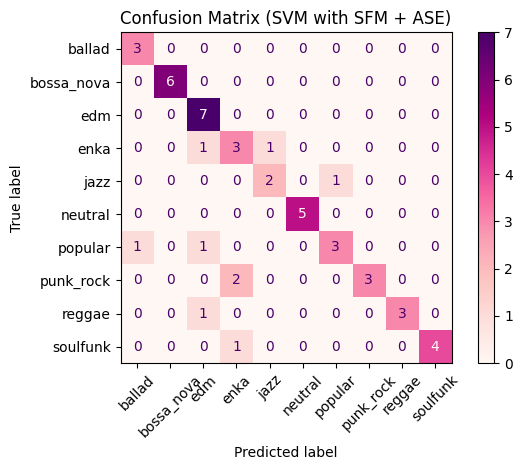

In [199]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# SFM・ASEの統合ファイルを再読み込み
df_sfm = pd.read_csv('data/sfm_features.csv')
df_ase = pd.read_csv('data/ase_features.csv')
df_combined = pd.merge(df_sfm, df_ase, on='filename')

# ラベル（ジャンル名）を抽出
df_combined['label'] = df_combined['filename'].apply(lambda x: x.split('/')[1])

# 特徴量とラベルに分割
X = df_combined[[col for col in df_combined.columns if col.startswith('sfm_band_') or col.startswith('ase_band_')]]
y = df_combined['label']

# 特徴量をスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 訓練・テスト分割（層化あり）
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# SVM学習
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train, y_train)

# 予測
y_pred = svm_clf.predict(X_test)

# 混同行列の作成と表示
labels = svm_clf.classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 表示
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='RdPu')
plt.title('Confusion Matrix (SVM with SFM + ASE)')
plt.tight_layout()
plt.show()

#### 交差検証

In [130]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# データの読み込みと統合
df_sfm = pd.read_csv("data/sfm_features.csv")
df_ase = pd.read_csv("data/ase_features.csv")
df_combined = pd.merge(df_sfm, df_ase, on="filename")

# ラベル（ジャンル）を抽出
df_combined["label"] = df_combined["filename"].apply(lambda x: x.split("/")[1])

# 特徴量とラベルに分割
X = df_combined[[col for col in df_combined.columns if col.startswith("sfm_band_") or col.startswith("ase_band_")]]
y = df_combined["label"]

# スケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SVM分類器（RBFカーネル）
clf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)

# 5分割 Stratified K-Fold で交差検証
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_scaled, y, cv=cv)

# 結果表示
print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation scores: [0.75925926 0.83018868 0.90566038 0.86792453 0.88679245]
Mean accuracy: 0.8499650593990218


#### データ数の確認

In [1]:
print(f"学習データ数: {len(X_train)}")
print(f"テストデータ数: {len(X_test)}")

NameError: name 'X_train' is not defined

#### 間違えたサンプルを表示する

In [132]:
# 予測と正解が異なるインデックスを取得
misclassified_indices = (y_test != y_pred)

# 間違えたサンプルだけを抽出
df_misclassified = pd.DataFrame({
    'filename': df_combined.iloc[y_test.index]['filename'],
    'true_label': y_test,
    'predicted_label': y_pred
})[misclassified_indices]

# 表示
print(df_misclassified)


                                            filename true_label  \
10   output_clips/soulfunk/yurikagonouta_clip000.wav   soulfunk   
172  output_clips/edm/yamaderanooshousan_clip002.wav        edm   
159         output_clips/enka/fujinoyama_clip000.wav       enka   
188            output_clips/edm/sunayama_clip006.wav        edm   
152   output_clips/enka/juugoyaotsukisan_clip001.wav       enka   
123        output_clips/jazz/nanatsunoko_clip000.wav       jazz   

    predicted_label  
10           ballad  
172            enka  
159             edm  
188            enka  
152             edm  
123          ballad  


## 4曲を学習、１曲をテスト


              precision    recall  f1-score   support

      ballad       0.67      0.54      0.60        26
  bossa_nova       0.96      0.93      0.95        28
         edm       0.66      0.64      0.65        33
        enka       0.62      0.59      0.60        27
        jazz       0.62      0.59      0.61        17
     neutral       0.77      0.74      0.76        23
     popular       0.44      0.83      0.58        23
   punk_rock       1.00      0.89      0.94        27
      reggae       1.00      0.84      0.91        19
    soulfunk       1.00      0.85      0.92        27

    accuracy                           0.74       250
   macro avg       0.77      0.74      0.75       250
weighted avg       0.78      0.74      0.75       250



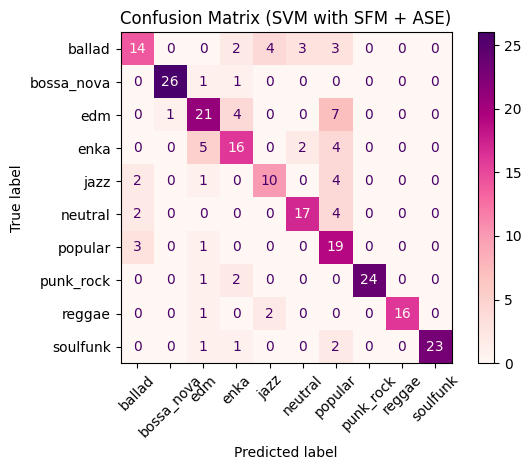

In [253]:
# ライブラリの再インポート（セッションリセットされたため）
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# アップロードされたファイルを再読み込み
sfm_path = 'data/sfm_features_30.csv'
ase_path = 'data/ase_features_30.csv'
df_sfm = pd.read_csv(sfm_path)
df_ase = pd.read_csv(ase_path)

# 結合
df = pd.merge(df_sfm, df_ase, on='filename')

# ラベルと曲名抽出
df['label'] = df['filename'].apply(lambda x: x.split('/')[1])       # ジャンル
df['song'] = df['filename'].apply(lambda x: x.split('/')[2])        # 曲名（3番目のディレクトリ）

# 結果保存用
all_true = []
all_pred = []

# 各ジャンルごとに1曲をテスト、残りを学習に使う
unique_labels = df['label'].unique()
for label in unique_labels:
    songs = df[df['label'] == label]['song'].unique()
    for test_song in songs:
        # 学習・テスト分割（曲単位）
        test_idx = (df['label'] == label) & (df['song'] == test_song)
        train_idx = (df['label'] != label) | (df['song'] != test_song)

        X_train = df.loc[train_idx, df.columns.str.startswith(('sfm_band_', 'ase_band_'))]
        y_train = df.loc[train_idx, 'label']
        X_test = df.loc[test_idx, df.columns.str.startswith(('sfm_band_', 'ase_band_'))]
        y_test = df.loc[test_idx, 'label']

        # スケーリング
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # SVM訓練・予測
        clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

        # 結果を蓄積
        all_true.extend(y_test)
        all_pred.extend(y_pred)

# 混同行列と分類レポート
labels = sorted(df['label'].unique())  # ← dfから使っていたものと一致
report = classification_report(all_true, all_pred, output_dict=False)
cm = confusion_matrix(all_true, all_pred, labels=labels)

# 表示
print(report)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='RdPu')
plt.title('Confusion Matrix (SVM with SFM + ASE)')
plt.tight_layout()
plt.show()


In [254]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
from tabulate import tabulate
# # SFM + ASE の結合済みデータを読み込み
# df_sfm = pd.read_csv("sfm_features.csv")
# df_ase = pd.read_csv("ase_features.csv")
# df = pd.merge(df_sfm, df_ase, on="filename")

# ジャンルと曲名を抽出
df["label"] = df["filename"].apply(lambda x: x.split("/")[1])
df["song"] = df["filename"].apply(lambda x: x.split("/")[2])

X = df[[col for col in df.columns if col.startswith("sfm_band_") or col.startswith("ase_band_")]]
y = df["label"]

# 曲ごとの精度記録
results = []

for label in df["label"].unique():
    for song in df[df["label"] == label]["song"].unique():
        test_idx = (df["label"] == label) & (df["song"] == song)
        train_idx = ~test_idx

        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]
        X_test = X.loc[test_idx]
        y_test = y.loc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        clf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        results.append({
            "genre": label,
            "song": song,
            "n_segments": len(y_test),
            "accuracy": acc
        })

# 表として出力
results_df = pd.DataFrame(results)
# accuracy を小数第2位に丸める
results_df["accuracy"] = results_df["accuracy"].round(2)

# ソート（ジャンル → 曲名）
results_df = results_df.sort_values(by=["genre", "song"])

# インデント付きで曲名を整形
results_df["song"] = results_df["song"].apply(lambda x: f"  {x}")

# 最初の曲だけ genre 表示、それ以降は空文字に
results_df["genre_display"] = results_df["genre"]
results_df.loc[results_df["genre_display"].duplicated(), "genre_display"] = ""

# 表示用 DataFrame
display_df = results_df[["genre_display", "song", "n_segments", "accuracy"]]
display_df.columns = ["genre", "song", "n_segments", "accuracy"]

# tabulate を使って整形表示（print用）
print(tabulate(display_df, headers='keys', tablefmt='github', showindex=False))


| genre      | song                     |   n_segments |   accuracy |
|------------|--------------------------|--------------|------------|
| ballad     | doubutsuen               |            3 |       0.67 |
|            | hiyoko                   |            6 |       0.67 |
|            | kakashi                  |            8 |       0.25 |
|            | nakayoshikomichi         |            4 |       0.25 |
|            | shikararete              |            5 |       1    |
| bossa_nova | dongurikorokoro          |            7 |       0.86 |
|            | haruyokoi                |            5 |       0.8  |
|            | ryousen                  |            5 |       1    |
|            | touriyanse               |            6 |       1    |
|            | urashimatarou            |            5 |       1    |
| edm        | koganemushi              |            5 |       1    |
|            | meemeekoyagi             |            6 |       0.5  |
|            | momij

              precision    recall  f1-score   support

      ballad       0.50      0.31      0.38        16
  bossa_nova       0.96      0.79      0.86        28
         edm       0.62      0.61      0.62        33
        enka       0.47      0.67      0.55        27
        jazz       0.75      0.53      0.62        17
     neutral       0.71      0.52      0.60        23
     popular       0.14      0.26      0.18        23
   punk_rock       1.00      0.89      0.94        27
      reggae       0.88      0.79      0.83        19
    soulfunk       1.00      0.85      0.92        27

    accuracy                           0.64       240
   macro avg       0.70      0.62      0.65       240
weighted avg       0.71      0.64      0.67       240



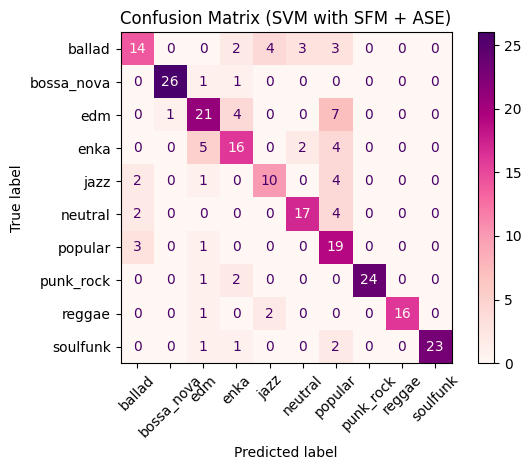

In [255]:
from sklearn.model_selection import GroupKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# データ読み込み & 結合
df_sfm = pd.read_csv("data/sfm_features.csv")
df_ase = pd.read_csv("data/ase_features.csv")
df = pd.merge(df_sfm, df_ase, on="filename")

# ラベルと曲名抽出
df["label"] = df["filename"].apply(lambda x: x.split('/')[1])  # ジャンル
df["song"] = df["filename"].apply(lambda x: x.split('/')[2])   # 曲名

# 特徴量・ラベル・グループ
X = df[[col for col in df.columns if col.startswith("sfm_band_") or col.startswith("ase_band_")]]
y = df["label"]
groups = df["song"]  # 曲単位でfoldを分ける

# モデル・評価用リスト
all_true, all_pred = [], []

# GroupKFold（曲ごとに分割）を使った5分割CV
gkf = GroupKFold(n_splits=5)
for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # スケーリング
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # SVM訓練・予測
    clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    # 保存
    all_true.extend(y_test)
    all_pred.extend(y_pred)

# 結果出力
print(classification_report(all_true, all_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='RdPu')
plt.title('Confusion Matrix (SVM with SFM + ASE)')
plt.tight_layout()
plt.show()

In [256]:
from sklearn.metrics import accuracy_score

# fold番号と精度を記録
fold_accuracies = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append((fold, acc))
    print(f"Fold {fold}: accuracy = {acc:.4f}")

# 平均精度
mean_acc = np.mean([a for _, a in fold_accuracies])
print(f"\nMean accuracy over 5 folds: {mean_acc:.4f}")

Fold 1: accuracy = 0.7347
Fold 2: accuracy = 0.7083
Fold 3: accuracy = 0.5625
Fold 4: accuracy = 0.6383
Fold 5: accuracy = 0.5625

Mean accuracy over 5 folds: 0.6413
